# Von Neumann Stability Analysis for the FTCS Method


## Run the 2 cell blocks below to study how Fourier modes can represent an actual temperature field.
For a real temperature field, Fourier coefficients must come in complex-conjugate pairs so that imaginary parts cancel and the reconstructed field is real.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

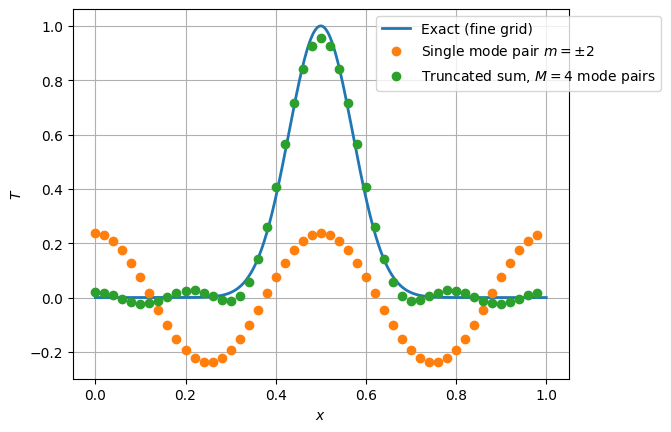

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Coarse grid (Fourier representation lives here)
# -----------------------------
N = 50
L = 1.0
dx = L / N
j = np.arange(N)
x = j * dx

# -----------------------------
# Fine grid (for "exact" smooth blue curve)
# -----------------------------
N_fine = 1000
x_fine = np.linspace(0.0, L, N_fine)

# -----------------------------
# Exact temperature profile (define it continuously)
# -----------------------------
def T_exact(x):
    return np.exp(-100*(x - 0.5)**2)   # smooth localized bump

T_coarse = T_exact(x)
T_fine   = T_exact(x_fine)

# -----------------------------
# Fourier amplitudes A_m from coarse samples
# T_j = sum_m A_m * exp(i k_m x_j)
# -----------------------------
A = np.fft.fft(T_coarse) / N
k = 2*np.pi * np.fft.fftfreq(N, d=dx)   # physical wavenumbers (rad/length)

# -----------------------------
# (1) Single Fourier mode pair (choose m)
# -----------------------------
m = 2  # try 1, 2, 3, 5, ...
T_one_mode = np.real(
    A[m]  * np.exp(1j * k[m]  * x) +
    A[-m] * np.exp(1j * k[-m] * x)
)

# -----------------------------
# (2) Truncated Fourier reconstruction using +/-1..M mode pairs
# -----------------------------
M = 4  # try 1, 3, 5, 10, 20...
A_trunc = np.zeros_like(A, dtype=complex)
A_trunc[0] = A[0]
for mm in range(1, M+1):
    A_trunc[mm]  = A[mm]
    A_trunc[-mm] = A[-mm]

T_rec = np.real(np.fft.ifft(A_trunc * N))

# -----------------------------
# Plot: exact (fine) vs sampled (coarse) vs Fourier approximations
# -----------------------------
plt.figure()
plt.plot(x_fine, T_fine, label='Exact (fine grid)', linewidth=2)
#plt.plot(x, T_coarse, 'o', label='Exact (coarse grid)')
plt.plot(x, T_one_mode, 'o', label=fr'Single mode pair $m=\pm{m}$')
plt.plot(x, T_rec, 'o', label=fr'Truncated sum, $M={M}$ mode pairs')
plt.xlabel('$x$')
plt.ylabel('$T$')
#plt.title('Exact vs Fourier-mode approximations (fine vs coarse grid)')
plt.grid(True)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

## Big picture: why we use Fourier modes
- Any (reasonable) temperature profile on a grid can be written as a **sum of Fourier modes**.
- Because FTCS is **linear** with **constant coefficients**, it advances **each Fourier mode independently**.
- For a single mode, one time step multiplies its amplitude by the **amplification factor**:
  \begin{equation}
  G(\theta)=\frac{A^{n+1}}{A^n}.
  \end{equation}
  Stability means **no mode grows**: $|G(\theta)|\le 1$ for all $\theta\in[0,\pi]$.


Largest |A_m| values (index, |A_m|):
63 0.5
1 0.5
31 5.81722615087015e-17
0 4.5498437957585015e-17
25 4.2997679988954136e-17
40 3.596914159155656e-17


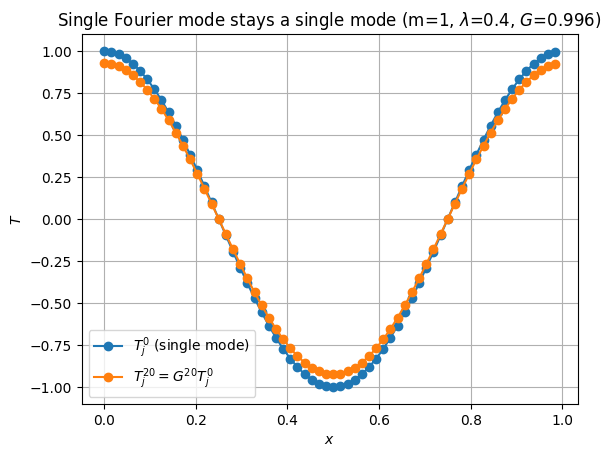

In [3]:
# ---------------------------------------------------------
# Demo: "single Fourier mode stays a single Fourier mode"
# ---------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

N = 64
L = 1.0
dx = L / N
j = np.arange(N)
x = j * dx

# A single spatial Fourier mode (cosine) on the grid
m = 1  # mode index
T0 = np.cos(2*np.pi*m*x/L)

# FFT amplitudes (should be concentrated at +/-m)
A = np.fft.fft(T0) / N
amps = np.abs(A)

# Show the largest few Fourier amplitudes
top = np.argsort(amps)[::-1][:6]
print("Largest |A_m| values (index, |A_m|):")
for idx in top:
    print(idx, amps[idx])

# FTCS amplification factor for this mode:
# theta = k*dx, with k = 2πm/L  --> theta = 2πm/N
theta = 2*np.pi*m/N

lam = 0.4  # try 0.4 (stable), 0.5 (borderline), 0.6 (unstable)
G = 1 + 2*lam*(np.cos(theta) - 1)

# After n steps, the mode is scaled by G^n (shape unchanged)
nsteps = 20
Tn = (G**nsteps) * T0

plt.figure()
plt.plot(x, T0, marker='o', label=r'$T_j^0$ (single mode)')
plt.plot(x, Tn, marker='o', label=fr'$T_j^{{{nsteps}}} = G^{{{nsteps}}} T_j^0$')
plt.xlabel('$x$')
plt.ylabel('$T$')
plt.title(fr'Single Fourier mode stays a single mode (m={m}, $\lambda$={lam}, $G$={G:.3f})')
plt.grid(True)
plt.legend()
plt.show()


**Figure caption** — Single Fourier mode under FTCS time stepping.
The blue curve shows the initial temperature profile $T_j^0$, consisting of a single Fourier mode. After 20 FTCS time steps, the orange curve shows $T_j^{20} = G^{20} T_j^0$. The spatial shape of the mode is unchanged, and only the amplitude is reduced by repeated multiplication by the amplification factor $G$. In this example, $G = 0.996 < 1$, so the mode decays slightly at each time step. This illustrates that FTCS advances each Fourier mode independently, scaling its amplitude without altering its shape.

Next, plug in single Fourier mode into the FTCS update:

\begin{equation}
T_{j}^{n+1} = (1-2\lambda)T_j^n + \lambda(T_{j+1}^n + T_{j-1}^n)
\end{equation}

\begin{equation}
A^{n+1} \mathrm{e}^{\mathrm{i}\theta j}=(1-2\lambda)A^n\mathrm{e}^{\mathrm{i}\theta j}+\lambda(A^n\mathrm{e}^{\mathrm{i}\theta j+1} + A^n\mathrm{e}^{\mathrm{i}\theta j-1})\qquad \qquad(1)
\end{equation}

Now utilize some useful identities:

$\mathrm{e}^{\mathrm{i} \theta (\mathrm{j}+1)}$

$\mathrm{e}^{\mathrm{i}\theta(\mathrm{j}+1)}
= \mathrm{e}^{\mathrm{i}\theta\,\mathrm{j}}\,\mathrm{e}^{\mathrm{i}\theta}$

$\mathrm{e}^{\mathrm{i} \theta (\mathrm{j}-1)}$


$\mathrm{e}^{\mathrm{i} \theta} + \mathrm{e}^{-\mathrm{i} \theta}$

Substituting the above identities into equation (1) gives:


$A^{n+1} = A^n[1+2\lambda(\cos{\theta}-1)]$

$\frac{A^{n+1}}{A^n}=A(\theta)$

$A(\theta) = [1+2\lambda(\cos{\theta}-1)]$ Amplification factor $|{A(\theta)}|\le 1$

If $|A(\theta)|<1$: mode decays (diffusion-like)

Hence, we want to ensure that the amplitude does not grow over a time step $n$.

#### Run the code cells below to examine how $\lambda$ affects the amplification factor.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.pi

3.141592653589793

In [6]:
lam = 0.5

theta = np.linspace(0.0,np.pi,21)
A = 1+2*lam*(np.cos(theta)-1)
A

array([ 1.00000000e+00,  9.87688341e-01,  9.51056516e-01,  8.91006524e-01,
        8.09016994e-01,  7.07106781e-01,  5.87785252e-01,  4.53990500e-01,
        3.09016994e-01,  1.56434465e-01,  1.11022302e-16, -1.56434465e-01,
       -3.09016994e-01, -4.53990500e-01, -5.87785252e-01, -7.07106781e-01,
       -8.09016994e-01, -8.91006524e-01, -9.51056516e-01, -9.87688341e-01,
       -1.00000000e+00])

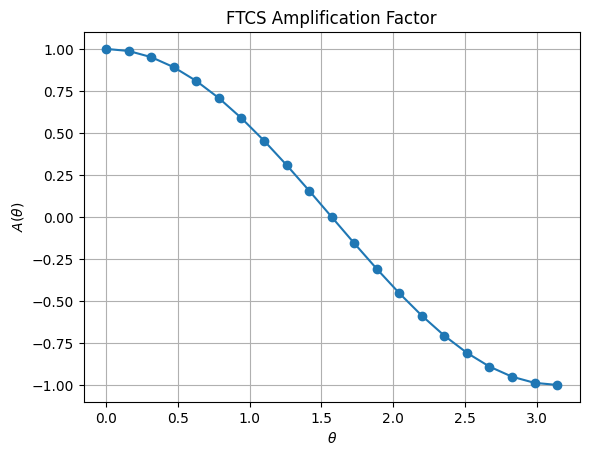

In [7]:
plt.plot(theta, A, marker='o')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$A(\theta)$')
plt.title('FTCS Amplification Factor')
plt.grid(True)
plt.show()

Notice that for all $\lambda$, the amplification factor takes on its minimum value when $\theta = \pi$. Hence we evaluate $G(\theta)$ at $\theta=\pi$:

\begin{equation}
G(\pi)=1+2\lambda(\cos\pi-1)
=1+2\lambda(-1-1)
=1-4\lambda
\end{equation}

So the smallest amplification factor is
\begin{equation}
\boxed{G_{\min}=1-4\lambda.}
\end{equation}

Enforce stability at the worst case

We need $|G(\theta)|\le 1$ for all $\theta$, in particular at $\theta=\pi$:
\begin{equation}
|G(\pi)|\le 1
\quad\Rightarrow\quad
|1-4\lambda|\le 1.
\end{equation}

Finally, solve the inequality:
\begin{equation}
-1 \le 1-4\lambda \le 1.
\end{equation}

\begin{equation}
1-4\lambda \le 1 \;\Rightarrow\; -4\lambda \le 0 \;\Rightarrow\; \lambda \ge 0.
\end{equation}

\begin{equation}
-1 \le 1-4\lambda
\;\Rightarrow\;
-2 \le -4\lambda
\;\Rightarrow\;
2 \ge 4\lambda
\;\Rightarrow\;
\lambda \le \tfrac12.
\end{equation}

### Final restriction
\begin{equation}
\boxed{0 \le \lambda \le \tfrac12.}
\end{equation}
Since $\lambda=\alpha\Delta t/\Delta x^2$ with $\alpha>0$, you typically just report:
$\lambda \le \tfrac12\$.

## Takeaway
- A Fourier mode has the form $T_j^n = A^n\,\mathrm{e}^{\mathrm{i}\theta j}$.
- FTCS multiplies each mode by the same factor each step:
  \begin{equation}
  G(\theta)=\frac{A^{n+1}}{A^n}=1+2\lambda(\cos\theta-1).
  \end{equation}
- The **worst-case mode** is $\theta=\pi$. Requiring $|G(\theta)|\le 1$ for all $\theta$ gives the FTCS restriction:
  \begin{equation}
  \boxed{\lambda=\frac{\alpha\Delta t}{\Delta x^2}\le \frac{1}{2}.}
  \end{equation}
